In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE, Isomap
from sklearn.metrics import accuracy_score
import gensim.downloader as api
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from collections import Counter
from images import correct_image, save_corrected_image, get_descriptors, correct_descriptor
from images import add_descriptors_to_vocab
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from time import perf_counter
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import cv2 as cv
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten
from keras import Model
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

2022-01-17 09:22:17.940903: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ilyes/anaconda3/envs/env_p6/lib/python3.10/site-packages/cv2/../../lib64:
2022-01-17 09:22:17.940929: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package punkt to /home/ilyes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ilyes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ilyes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

On commence par charger la base de données:

In [2]:
data = pd.read_csv("Flipkart/flipkart_com-ecommerce_sample_1050.csv")

Voyons un extrait de son contenu:

In [3]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


Pour classer les produits, on va utiliser:
- La description
- La photo

# Introduction

In [4]:
print("On a %d produits à classer" % len(data))

On a 1050 produits à classer


# Catégories

On va **formatter les listes des catégories**, car elles sont sous forme de chaîne de caractère.

In [5]:
# product_category_list: Série associant à chaque produit la liste de ses (sous-)catégories
product_category_list = data['product_category_tree'].str.split('>>')

Il reste des ajustements à faire:
- Enlever les espaces à la fin des noms de catégorie
- Enlever les espaces et les autres caractères indésirables au début des noms des catégories.

En effet, on peut le constater sur le 1er élément de la liste

In [6]:
product_category_list.iloc[0]

['["Home Furnishing ',
 ' Curtains & Accessories ',
 ' Curtains ',
 ' Elegance Polyester Multicolor Abstract Eyelet Do..."]']

In [7]:
def format_category_list(category_list):
    """Corrige les noms de catégories en supprimant les caractères indésirables"""
    category_list[0] = category_list[0][2:]
    for i in range(len(category_list)-1):
        category_list[i] = category_list[i][:-1]
    category_list[-1] = category_list[-1][:-2]
    return category_list
# On applique les corrections sur l'ensemble des listes de catégories
product_category_list = product_category_list.map(format_category_list)

On enregistre les listes de (sous-)catégories dans une liste.

In [8]:
data['product_category_tree'] = product_category_list

# Exploration des données

## Répartition des longueurs de description

Text(0.5, 1.0, 'Boxplot des longueurs de description')

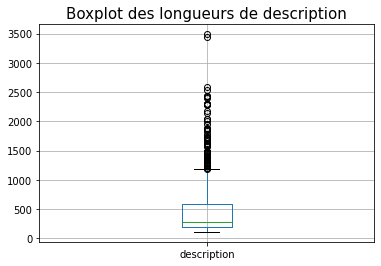

In [9]:
description_lengths = data['description'].map(len)
description_lengths.to_frame().boxplot()
plt.title("Boxplot des longueurs de description", fontsize=15)

Text(0, 0.5, 'Longueur de la description')

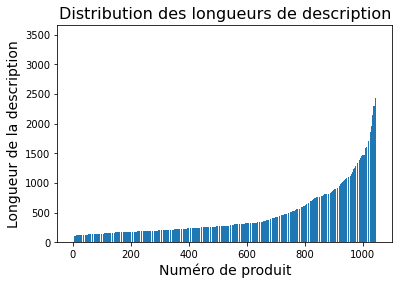

In [10]:
plt.bar(np.arange(len(data)), sorted(description_lengths))
plt.title("Distribution des longueurs de description", fontsize=16)
plt.xlabel("Numéro de produit", fontsize=14)
plt.ylabel("Longueur de la description", fontsize=14)

## Nombre de catégories

In [11]:
# height_categ_tree: Hauteur de l'arbre des catégories
height_categ_tree = data['product_category_tree'].map(len)

Text(0.5, 1.0, 'Boxplot du nombre de (sous-)catégories')

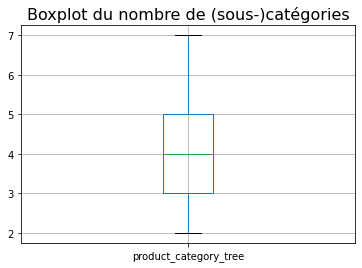

In [12]:
height_categ_tree.to_frame().boxplot()
plt.title("Boxplot du nombre de (sous-)catégories", fontsize=16)

**Un produit est donc dans 2 catégories au moins**.

Voyons combien il y à de dernière catégories.

In [13]:
# get_last_categ: Retourne le dernier élément d'une liste
get_last_categ = lambda categ_list: categ_list[-1]
# On enregistre la dernière catégorie de chaque produit dans une colonne
data['product_last_category'] = product_category_list.map(get_last_categ)

In [14]:
# nb_categ_last: Nombre de feuilles de l'arbre des catégories
nb_categs_last = len(data['product_last_category'].unique())

In [15]:
print("Il y à %d dernières catégories" % nb_categs_last)

Il y à 642 dernières catégories


Il n'y à donc **pas assez de produits pour utiliser les catégories les plus précises**. On utilisera donc la première catégories.

In [16]:
# get_first_categ: Retourne le 1er élément d'une liste
get_first_categ = lambda categ_list: categ_list[0]

In [17]:
# On enregistre la première catégorie de chaque produit dans une colonne
data['product_first_category'] = product_category_list.map(get_first_categ)

In [18]:
# n_categs: Nombre de catégories (premières)
n_categs = len(data['product_first_category'].unique())

On va pouvoir tester de prédire chacune de ses variables.

In [19]:
# expected_categ: Catégorie réelle de chaque produit
expected_categ = data['product_first_category']
# label_enc: Encoder d'étiquettes en entiers
label_enc = LabelEncoder()
expected_categ = label_enc.fit_transform(expected_categ)

In [20]:
print("On va utiliser la classification en %d catégories" % n_categs)

On va utiliser la classification en 7 catégories


## Répartition des produits dans les catégories

In [21]:
# count_per_categ: Série associant à une catégorie son effectif
count_per_categ = data.groupby('product_first_category').count()['uniq_id']

Text(0.5, 0, 'Nom de catégorie')

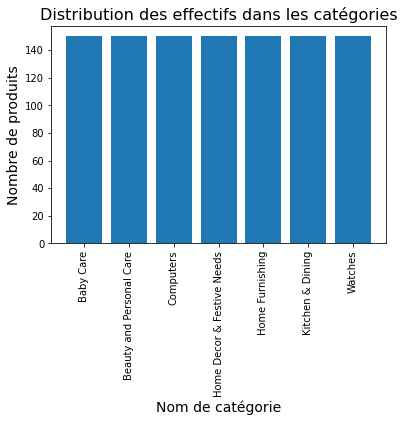

In [22]:
plt.bar(count_per_categ.index, count_per_categ)
plt.xticks(rotation = 90)
plt.title("Distribution des effectifs dans les catégories", fontsize=16)
plt.ylabel('Nombre de produits', fontsize=14)
plt.xlabel('Nom de catégorie', fontsize=14)

On a donc suffisamment de produits dans chacune des catégories pour créer nos modèles.

# Tranformation du texte
On doit changer la représentation de l'information pour pouvoir l'utiliser dans une classification.

## Étude des mots clés: Bag-of-words
Une première méthode consiste à représenter les descriptions par les fréquences d'apparition des mots d'un corpus.

### Repérage stopwords
Certains mots ne contiennent pas d'informations spécifiques aux produits. On va les supprimer de l'étude.

In [23]:
# stopwords: Mots inutiles définis dans nltk
stopwords = tuple(nltk.corpus.stopwords.words('english'))

In [24]:
# tokenizer: Tansforme une description en liste de mots
tokenizer = nltk.RegexpTokenizer(r'\w+')
# stemmer: Racinise une liste de mots
stemmer = EnglishStemmer()
# Lemmatizer: Lemminise une liste de mots
lemmatizer = WordNetLemmatizer()
def tokenize(text, lemmitize=True, stem=True, del_stopwords=True):
    """Fonction retournant la liste des mots clés d'un texte, lemminisée et racinisée"""
    tokens = tokenizer.tokenize(text)
    tokens = [word for word in tokens if not re.match('^[0-9]+$', word)]  # Suppression des entiers
    # Suppression des stopwords
    tokens = [word for word in tokens if not word in stopwords] if del_stopwords else tokens
    # Racinisation
    tokens = [stemmer.stem(word) for word in tokens] if stem else tokens
    # Lemminisation
    tokens = [lemmatizer.lemmatize(word) for word in tokens] if lemmitize else tokens
    return tokens

Voyons ce que cela donne sur la première description:

In [25]:
print("Avant le pré-traitement:\n%s" % data['description'].iloc[0])

Avant le pré-traitement:
Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light 

In [26]:
print("Après le pré-traitrement:\n%s" % tokenize(data['description'].iloc[0]))

Après le pré-traitrement:
['key', 'featur', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'eleg', 'polyest', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'cm', 'height', 'pack', 'price', 'r', 'this', 'curtain', 'enhanc', 'look', 'interior', 'this', 'curtain', 'made', 'high', 'qualiti', 'polyest', 'fabric', 'it', 'featur', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'it', 'make', 'room', 'environ', 'romant', 'love', 'this', 'curtain', 'ant', 'wrinkl', 'anti', 'shrinkag', 'eleg', 'appar', 'give', 'home', 'bright', 'modernist', 'appeal', 'design', 'the', 'surreal', 'attent', 'sure', 'steal', 'heart', 'these', 'contemporari', 'eyelet', 'valanc', 'curtain', 'slide', 'smooth', 'draw', 'apart', 'first', 'thing', 'morn', 'welcom', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morn', 'whole', 'world', 'draw', 'close', 'even', 'creat', 'special', 'moment', 'joyous', 'beauti', 'given', 'sooth', 'print', 'bring', 'home', 'eleg', 'curt

### tf-idf: Term Frequency - Inverse Document Frequency

On commence par enlever les majuscules des descriptions:

In [27]:
data['description'] = data['description'].str.lower()

Et on applique l'algorithme TF-IDF.

In [28]:
# tfidf: Objets réalisant la classification des description
tfidf = TfidfVectorizer(tokenizer=tokenize, stop_words=stopwords)

In [29]:
# tfidf_vects: Vecteurs TF-IDF pour chaque description
tfidf_vects = tfidf.fit_transform(data['description'])

In [30]:
print("Les vecteurs de TF-IDF sont de taille %d" % tfidf_vects.shape[1])

Les vecteurs de TF-IDF sont de taille 4378


La matrice obtenue est d'un type particulier pour représenter une matrice creuse: On la caste en matrice numpy.

In [31]:
tfidf_vects = np.array(tfidf_vects.todense())

La matrice obtenue est creuse comme on peut le constater:

In [32]:
density = np.count_nonzero(tfidf_vects)/float(tfidf_vects.size)
print("La matrice de TF-IDF a une densité de %.1f%s" % (density*100, '%'))

La matrice de TF-IDF a une densité de 0.8%


On va donc utiliser TruncatedSVD pour la réduction de dimensions

In [33]:
# n_components_list: Nombre de composantes principales à tester
n_components_list = np.arange(50, 600+50, 50)
# n_comonents_ratio: Ratio de la variance expliquée pour chaque nombre de composantes testé
n_components_ratio = {}
for n_components in n_components_list:
    svd = TruncatedSVD(n_components=n_components)
    tfidf_svd = svd.fit_transform(tfidf_vects)
    n_components_ratio[n_components] = sum(svd.explained_variance_ratio_)*100
# ser: Série contenant le ratio de la variance représentée pour chaque nombre de composantes
ser = pd.Series(n_components_ratio)
ser.index.name = 'n_components'
ser.name = 'explained_variance_ratio_total'

Text(0.5, 1.0, 'Analyse sémantique latente pour TF-IDF')

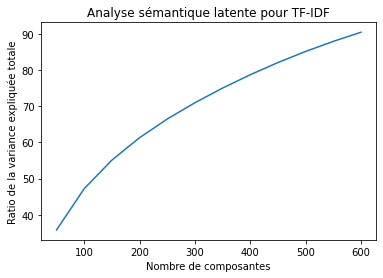

In [34]:
plt.plot(ser.index, ser)
plt.xlabel("Nombre de composantes")
plt.ylabel("Ratio de la variance expliquée totale")
plt.title("Analyse sémantique latente pour TF-IDF")

On réalise la réduction dimensionnelle optimale avec TruncatedSVD:

In [35]:
svd = TruncatedSVD(n_components=600)
tfidf_projected = svd.fit_transform(tfidf_vects)

On peut déjà visualiser nos données avec l'algorithme T-SNE.

In [36]:
tsne = TSNE(n_components=2, perplexity=5, init='pca')
tfidf_tsne = tsne.fit_transform(tfidf_svd)

/home/ilyes/anaconda3/envs/env_p6/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ilyes/anaconda3/envs/env_p6/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


/home/ilyes/anaconda3/envs/env_p6/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ilyes/anaconda3/envs/env_p6/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


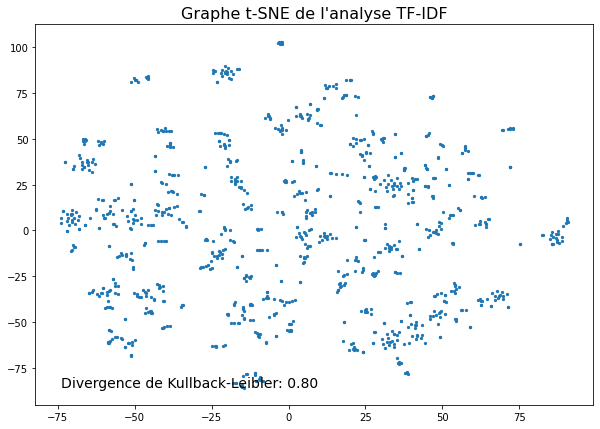

In [37]:
tsne = TSNE(n_components=2, perplexity=5, init='pca')
tfidf_tsne = tsne.fit_transform(tfidf_svd)
plt.figure(figsize=(10,7))
plt.scatter(tfidf_tsne[:, 0], tfidf_tsne[:, 1], s=5)
plt.title("Graphe t-SNE de l'analyse TF-IDF", fontsize=16)
_ = plt.text(min(tfidf_tsne[:, 0]), min(tfidf_tsne[:, 1]),
         "Divergence de Kullback-Leibler: %.2f" % tsne.kl_divergence_, fontsize=14)

On voit se former plusieurs groupuscules, ce qui est le signe que notre représentation fait apparaître de nombreuses catégories.

Voyons quelle précision moyenne on atteint avec cette transformation des descriptions.

In [25]:
params = {'learning_rate': [0.8],
          'n_estimators':[50],
          'max_depth': [10]}
gradboost = GradientBoostingClassifier()
g_gradboost = GridSearchCV(gradboost, params, scoring='accuracy', cv=3)

In [39]:
# scores: Scores obtenus sur plusieurs classifications des les vecteurs obtenus avec TF-IDF
scores = []
# Sur chaque boucle, on calcule la précision obtenue pour une classfication
for n_iter in range(5):
    vect_train, vect_test, categ_train, categ_test = train_test_split(tfidf_projected, expected_categ, train_size=0.8)
    g_gradboost.fit(vect_train, categ_train)
    scores.append(g_gradboost.score(vect_test, categ_test))
print("Avec le TF-IDF, on obtiens la précision moyenne: %.2f" % np.mean(scores))

Avec le TF-IDF, on obtiens la précision moyenne: 0.88


### Doc2Vec

In [21]:
descs = data['description']
tags = expected_categ
tagged_data = [TaggedDocument(words=word_tokenize(desc), tags=tags) for ind, (desc, tag) in enumerate(zip(descs, tags))]

In [22]:
def model_doc2vec(tagged_data, vec_size, alpha, min_alpha, min_count, dm, max_epochs):
    """Entraîne un modèle Doc2Vec et retourne le modèle"""
    model = Doc2Vec(vector_size=vec_size,
                    alpha = alpha, # Taux d'apprentissage initial
                    min_alpha = min_alpha,  # Taux d'apprentissage minimal
                    min_count = min_count,  # Fréquence minimale d'apparition d'un mot
                    dm = dm)  # Distributed Memory (0: Distributed bag-of-words)
    model.build_vocab(tagged_data)
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=max_epochs)
    return model

Entraînons à présent notre modèle

In [23]:
def vects_doc2vec(tagged_data, model):
    return [model.infer_vector(td.words) for td in tagged_data]    

On va tester plusieurs tailles de vecteurs possibles et choisir celle qui optimise la classification des produits.

Essayons avec un modèle à distribution mémorielle.

In [26]:
vec_sizes = np.arange(100, 250, 50)
scores = []
n_mean = 3
for vec_size in vec_sizes:
    model = model_doc2vec(tagged_data, vec_size, 0.03, 0.03, 1, 1, 10)
    doc2vec = vects_doc2vec(tagged_data, model)
    vect_train, vect_test, categ_train, categ_test = train_test_split(doc2vec, expected_categ, train_size=0.8)
    scores_mean = []
    for i in range(n_mean):
        gradboost.fit(vect_train, categ_train)
        scores_mean.append(gradboost.score(vect_test, categ_test))
    scores.append(np.mean(scores_mean))

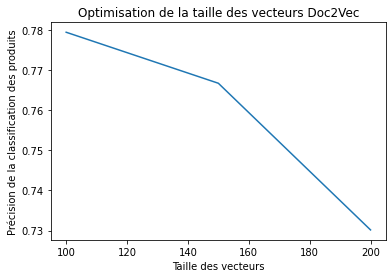

In [27]:
plt.title("Optimisation de la taille des vecteurs Doc2Vec")
plt.xlabel("Taille des vecteurs")
plt.ylabel("Précision de la classification des produits")
plt.plot(vec_sizes, scores)

On va finalement utiliser des vecteurs de taille 100. Optimisons les autres paramètres de cette vectorisation.

In [52]:
alphas_init = [0.01+0.005*float(i) for i in range(6)] 
scores = []
for alpha in alphas_init:
    model = model_doc2vec(tagged_data, vec_size, alpha, alpha/100, 1, 1, 10)
    doc2vec = vects_doc2vec(tagged_data, model)
    vect_train, vect_test, categ_train, categ_test = train_test_split(doc2vec, expected_categ, train_size=0.8)
    scores_mean = []
    for i in range(n_mean):
        g_gradboost.fit(vect_train, categ_train)
        scores_mean.append(g_gradboost.score(vect_test, categ_test))
    scores.append(np.mean(scores_mean))

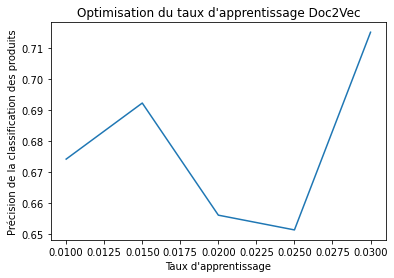

In [53]:
plt.title("Optimisation du taux d'apprentissage Doc2Vec")
plt.xlabel("Taux d'apprentissage")
plt.ylabel("Précision de la classification des produits")
plt.plot(alphas_init, scores)

In [57]:
mins_count = np.arange(1, 20, 5)
scores = []
n_mean = 5
for min_count in mins_count:
    model = model_doc2vec(tagged_data, vec_size, alpha, alpha/100, min_count, 1, 10)
    doc2vec = vects_doc2vec(tagged_data, model)
    vect_train, vect_test, categ_train, categ_test = train_test_split(doc2vec, expected_categ, train_size=0.8)
    scores_mean = []
    for i in range(n_mean):
        g_gradboost.fit(vect_train, categ_train)
        scores_mean.append(g_gradboost.score(vect_test, categ_test))
    scores.append(np.mean(scores_mean))

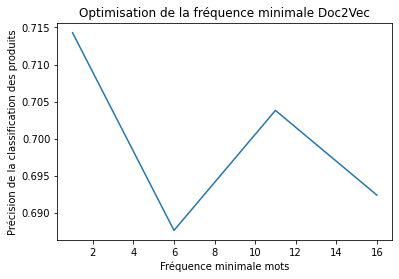

In [58]:
plt.title("Optimisation de la fréquence minimale Doc2Vec")
plt.xlabel("Fréquence minimale mots")
plt.ylabel("Précision de la classification des produits")
plt.plot(mins_count, scores)

In [28]:
min_count=1
alpha = 0.03
vec_size = 100

In [29]:
model = model_doc2vec(tagged_data, vec_size, alpha, alpha/100, min_count, 0, 10)
doc2vec = vects_doc2vec(tagged_data, model)
vect_train, vect_test, categ_train, categ_test = train_test_split(doc2vec, expected_categ, train_size=0.8)
n_mean = 5
scores_mean = []
for i in range(n_mean):
    g_gradboost.fit(vect_train, categ_train)
    scores_mean.append(g_gradboost.score(vect_test, categ_test))
print("Score avec distribution en bag-of-words: %.2f" % np.mean(scores_mean))

Score avec distribution en bag-of-words: 0.30


In [30]:
model = model_doc2vec(tagged_data, vec_size, alpha, alpha/100, min_count, 1, 10)
doc2vec = vects_doc2vec(tagged_data, model)
vect_train, vect_test, categ_train, categ_test = train_test_split(doc2vec, expected_categ, train_size=0.8)
n_mean = 5
scores_mean = []
for i in range(n_mean):
    g_gradboost.fit(vect_train, categ_train)
    scores_mean.append(g_gradboost.score(vect_test, categ_test))
print("Score avec distribution mémorielle: %.2f" % np.mean(scores_mean))

Score avec distribution mémorielle: 0.67


/home/ilyes/anaconda3/envs/env_p6/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ilyes/anaconda3/envs/env_p6/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


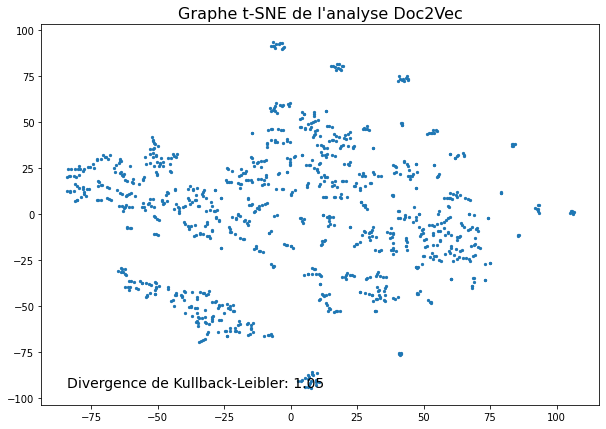

In [31]:
tsne = TSNE(n_components=2, perplexity=5, init='pca')
doc2vec_tsne = tsne.fit_transform(doc2vec)
plt.figure(figsize=(10,7))
plt.scatter(doc2vec_tsne[:, 0], doc2vec_tsne[:, 1], s=5)
plt.title("Graphe t-SNE de l'analyse Doc2Vec", fontsize=16)
_ = plt.text(min(doc2vec_tsne[:, 0]), min(doc2vec_tsne[:, 1]),
         "Divergence de Kullback-Leibler: %.2f" % tsne.kl_divergence_, fontsize=14)

# Classification des images

On va construire les descripteurs de chaque image et les rassembler pour obtenir le 'vocabulaire' de nos images. On calculera ensuite un vecteur par image, représentant la fréquence d'apparition de chaque mot/descripteur. Il ne restera plus qu'à classifier ces vecteurs avec un algorithme de classification non-supervisé.

## Corrections images

In [ ]:
dump = data['image'].apply(save_corrected_image, args=("Flipkart/Images/", "Flipkart/Images_corrected/",))

Maintenant, toutes nos images ont été traitées et stockées dans un dossier spécifique

## Bag-of-images

In [96]:
# path_correction: Chemin vers les images corrigées
path_correction = "Flipkart/Images_corrected/"+data['image']

In [97]:
# images_vocab: Ensemble des descripteurs des images
images_vocab = set()

On parcours les images et on enregistre les descripteurs rencontrés dans notre ensemble.

In [98]:
_ = path_correction.apply(add_descriptors_to_vocab, args=(images_vocab,))

On caste l'ensemble des descripteurs en array.

In [99]:
images_vocab = [np.array(desc) for desc in images_vocab]

In [100]:
images_vocab = np.array(images_vocab, ndmin=2)

In [101]:
print("On a %d descripteurs de %d dimensions" % images_vocab.shape)

On a 356441 descripteurs de 128 dimensions


La matrice est plutôt dense comme on peut le constater:

## Création des visual-words
On va classifier les descripteurs et chaque classe représentera un mot visuel.

In [75]:
density = np.count_nonzero(images_vocab)/float(images_vocab.size)
print("Densité de la matrice des mots visuels: %.1f" % density)

Densité de la matrice des mots visuels: 79.9


On, va pouvoir utiliser l'ACP pour réduire la taille de notre matrice.

In [102]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(images_vocab)

In [103]:
def explained_var_per_n_comps(data_scaled, n_components_list):
    dict_res = {}
    for n_components in n_components_list:
        pca = PCA(n_components=n_components)
        X_projected = pca.fit_transform(data_scaled)
        scree = pca.explained_variance_ratio_*100
        dict_res[n_components] = sum(scree)
    print("Pourcentage de l\'inertie totale par nombre de composantes principales")
    data = pd.DataFrame(data=dict_res, index=pd.Index(['Pourcentage de l\'inertie totale']))
    return data

In [104]:
#n_components_values = np.arange(step,images_vocab.shape[1]+step, step)
n_components_values = [58]
explained_var_per_n_comps(x_scaled, n_components_values)

Pourcentage de l'inertie totale par nombre de composantes principales


,58
Pourcentage de l'inertie totale,90.082312


In [105]:
pca_x = PCA(n_components=58)
X_projected = pca_x.fit_transform(x_scaled)

In [80]:
#tsne = TSNE(perplexity=5, n_components=2)
#X_tsne = tsne.fit_transform(X_projected)

In [81]:
#df = pd.DataFrame(X_tsne)
#df.to_csv('sift_tsne.csv')

In [82]:
df = pd.read_csv('sift_tsne.csv', index_col='Unnamed: 0')
X_tsne = df.to_numpy()

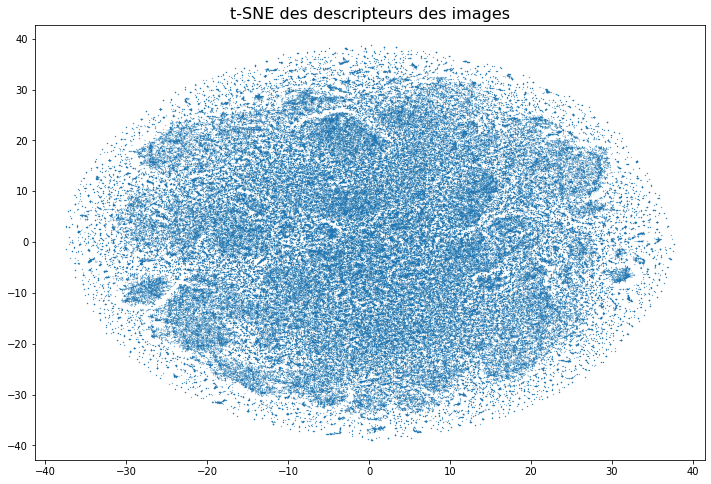

In [33]:
plt.figure(figsize=(12,8))
plt.title("t-SNE des descripteurs des images", fontsize=16)
plt.scatter(X_tsne[:,0,], X_tsne[:,1], s=0.01)
_ = plt.text(min(X_tsne[:, 0]), min(X_tsne[:, 1]),
         "Divergence de Kullback-Leibler: %.2f" % tsne.kl_divergence_, fontsize=14)

### Choix de l'algorithme de clustering
- KMeans: Possibilité d'utiliser la versio MiniBatch, mais nombre de clusters grand
- MeanShift: Ok pour le nombre de clusters
- DBSCAN: Ok pour la taille d'échantillon, mais limite pour le nombre de clusters
- AgglomerativeClustering: Peut fonctionner avec une matrice de connectivité
- BIRCH: ça a l'air OK

In [106]:
def list_search(classifier, data, param_name, param_values, scoring, kwargs=None, n_iter=1):
    """Calcule les scores pour un classifieur en fonction d'un paramètre"""
    # scores: Listes des scores
    scores = []
    # kwargs: Arguments nommés supplémentaires du classifieur
    kwargs = {} if kwargs is None else kwargs
    # param_value: Valeur du paramètre variable
    for param_value in param_values:
        aux_scores = []
        for iteration in range(n_iter):
            kwargs[param_name] = param_value  # Ajoute le paramètre variable
            # classifier: Classifieur construit
            classifier_ = classifier(**kwargs)
            # categs: Liste des catégories de chaque client
            categs = classifier_.fit_predict(data)
            aux_scores.append(scoring(data, categs))
        mean_score = np.mean(aux_scores)
        print("arg= %d; score = %f" % (param_value, mean_score))
        scores.append(mean_score)
    return scores

## Choix final

In [51]:
# n_cluster_list: Liste des nombres de clusters à essayer
n_clusters_list = np.arange(1000, 10_500, 1000)
# t_start: Début du compteur de performance
t_start = perf_counter()
scores_bkmeans = list_search(MiniBatchKMeans, X_projected_samp, 
                             'n_clusters', n_clusters_list, davies_bouldin_score, n_iter=10)
print("Duration: %.1fs" % (perf_counter()-t_start))

arg= 1000; score = 2.555939
arg= 2000; score = 2.275960
arg= 3000; score = 2.081137
arg= 4000; score = 1.930712
arg= 5000; score = 1.812687
arg= 6000; score = 1.718880
arg= 7000; score = 1.634833
arg= 8000; score = 1.573571
arg= 9000; score = 1.517772
arg= 10000; score = 1.483367
Duration: 21223.5s


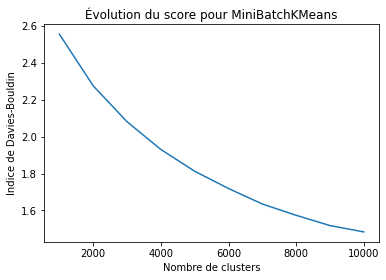

In [72]:
plt.title("Évolution du score pour MiniBatchKMeans")
plt.xlabel("Nombre de clusters")
plt.ylabel("Indice de Davies-Bouldin")
plt.plot(n_clusters_list, scores_bkmeans)

Au-delà de 10000 mots visuels, le score s'améliore très peu. On va donc s'arrêter à ce nombre de clusters

On utilise le nombre de clusters optimal.

In [107]:
# n_clusters: Nombre de clusters optimal pour MiniBatchKMeans
n_clusters = 10000
bkmeans = MiniBatchKMeans(n_clusters=n_clusters)
# categs_kmeans: Catégories prédites par MiniBatchKMeans
categs_kmeans = bkmeans.fit_predict(X_projected)

In [108]:
score = davies_bouldin_score(X_projected, categs_kmeans)
print("Score de la classification des descripteurs visuels: %.2f" % score)

Score de la classification des descripteurs visuels: 2.37


In [78]:
from gini import plot_lorenz_curve

-0.04232689589581451

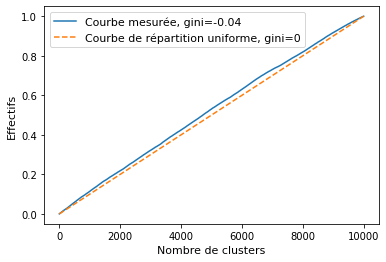

In [79]:
ser = pd.Series(categs_kmeans)
frame = ser.to_frame()
frame['Effectifs'] = 1
count_vizword = frame.groupby(0).count()
count_vizword.index.name = "Nombre de clusters"
plot_lorenz_curve(count_vizword['Effectifs'])
plt.title("Répartition des descripteurs dans les mots visuels")

On a une répartition plutôt équilibrée des fréquences des mots visuels.

On va maintenant calculer la fréquence de chaque mot visuel dans chaque image.

In [109]:
# n_vizwords: Nombre de mots visuels
n_vizwords = n_clusters

In [110]:
# freq_vizword: Fréquence de chaque mot visuel dans chaque image
freq_vizword = np.zeros((len(path_correction), n_vizwords))
# Parcourt chaque image et catégorise ses descripteurs dans chaque mot visuel
for ind, path_img in enumerate(path_correction):
    # descriptors: Descripteurs de l'image
    descriptors = get_descriptors(path_img)
    descriptors = [correct_descriptor(desc) for desc in descriptors]
    descriptors = scaler.transform(descriptors)
    descriptors = pca_x.transform(descriptors)
    label_vizwords = bkmeans.predict(descriptors.astype(np.float32))
    count = Counter(label_vizwords)
    for label_vizword, count_vizword in count.items():
        freq_vizword[ind][label_vizword] = count_vizword

In [111]:
freq_tot = freq_vizword.sum(axis=0)

In [112]:
freq_vizword = freq_vizword/freq_tot

In [91]:
density = np.count_nonzero(freq_vizword)/float(freq_vizword.size)
print("Densité de la matrice de fréquences des mots visuels %.2f%s" % (density, '%'))

Densité de la matrice de fréquences des mots visuels 0.03%


On peut donc utiliser TruncatedSVD pour la réduction dimensionnelle.

In [113]:
freq_vizword_scaled = scaler.fit_transform(freq_vizword)

In [ ]:
n_components_list = np.arange(50, 700+50, 50)
n_components_ratio = {}
for n_components in n_components_list:
    svd = TruncatedSVD(n_components=n_components)
    freq_vizword_svd = svd.fit_transform(freq_vizword_scaled)
    n_components_ratio[n_components] = sum(svd.explained_variance_ratio_)*100
ser = pd.Series(n_components_ratio)
ser.index.name = 'n_components'
ser.name = 'explained_variance_ratio_total'
ser

In [ ]:
plt.plot(ser.index, ser)
plt.xlabel("Nombre de composantes")
plt.ylabel("Ratio de la variance expliquée totale")
plt.title("Analyse sémantique latente pour SIFT")

In [114]:
svd = TruncatedSVD(n_components=700)
freq_vizword_projected = svd.fit_transform(freq_vizword_scaled)

Essayons de visualiser les données de nos images

In [97]:
tsne = TSNE(n_components=2, perplexity=5)
vizword_tsne = tsne.fit_transform(freq_vizword_projected)

/home/ilyes/anaconda3/envs/env_p6/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ilyes/anaconda3/envs/env_p6/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


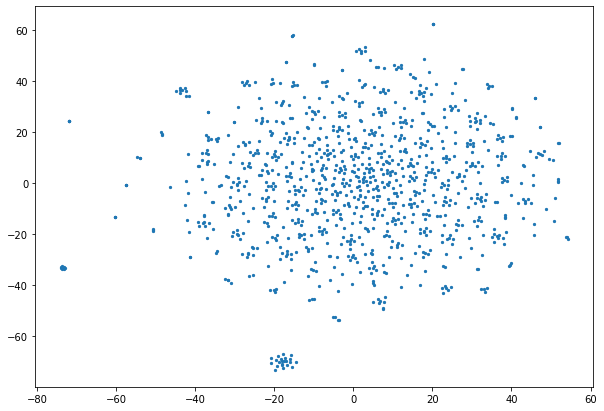

In [98]:
plt.figure(figsize=(10,7))
plt.scatter(vizword_tsne[:,0], vizword_tsne[:,1], s=5)
_ = plt.text(min(vizword_tsne[:, 0]), min(vizword_tsne[:, 1]),
         "Divergence de Kullback-Leibler: %.2f" % tsne.kl_divergence_, fontsize=14)
plt.title("T-SNE des vecteurs de fréquence des mots visuels", fontsize=16)

Voyons la précision de la prédiction obtenus avec cette transformation des images.

In [115]:
params = {'learning_rate': [0.8],
          'n_estimators':[50],
          'max_depth': [10]}
gradboost = GradientBoostingClassifier()
g_gradboost = GridSearchCV(gradboost, params, scoring='accuracy', cv=3)

In [116]:
scores = []
for n_iter in range(5):
    vect_train, vect_test, categ_train, categ_test = train_test_split(freq_vizword_projected, expected_categ, train_size=0.8)
    g_gradboost.fit(vect_train, categ_train)
    scores.append(g_gradboost.score(vect_test, categ_test))
print("Avec SIFT, on obtiens la précision: %.2f" % np.mean(scores))

Avec SIFT, on obtiens la précision: 0.33


## VGG-16

In [64]:
in_dir = "Flipkart/Images/"

Utilisation réseau

In [90]:
# model: VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# On paramètre le réseau pour réaliser un tuning partiel
for layer in model.layers:
   layer.trainable = False

# On va ajouter 2 couches denses: Une de 1024 neurones et une de 7 neurones
flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(n_categs, activation='softmax')(class1)

# new_model: Nouveau VGG-16 adapté au problème
new_model = Model(inputs=model.input, outputs=output)

Préparations des entrées.

In [91]:
def file_to_array(file_name, dir_path):
    """Retourne une image sous forme de tableau pour un CNN à partir d'un chemin vers un ficher"""
    img_path = dir_path+file_name
    img = load_img(img_path, target_size=(224, 224))  # Charger l'image
    img = img_to_array(img)  # Convertir en tableau numpy
    return img

In [178]:
# imgs_array: Contient un tableau pour chaque image
imgs_array = data['image'].apply(file_to_array, args=(in_dir,))

/home/ilyes/anaconda3/envs/env_p6/lib/python3.10/site-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [180]:
# imgs_array: Formatte les tableaux pour le traitement par CNN
imgs_array = np.array(imgs_array.to_list(), ndmin=4)

On **prépare les sorties attendues**, qui sont une liste de probabilités d'appartenance à chaque classe. On assigne une probabilité de 1 au groupe auquel le produit appartient, et une probabilité de 0 aux autres.

In [181]:
# expected_proba: Liste de probabilités attendues en sortie pour chaque produit
expected_proba = []
for categ in expected_categ:
    proba = np.zeros((n_categs))
    proba[categ] = 1
    expected_proba.append(proba)

In [182]:
# imgs_input: Tableaux des images pré-traités pour le CNN
imgs_input = preprocess_input(imgs_array)
# On sépare notre échantillon pour l'entraînement et le test
X_train, X_test, y_train, y_test = train_test_split(imgs_input, expected_proba, train_size=0.8)

Entraînement du modèle

In [183]:
from tensorflow.keras import optimizers
from tensorflow import stack

In [184]:
# Compiler le modèle 
new_model.compile(loss="categorical_crossentropy", optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.7), metrics=["accuracy"])

In [185]:
# Entraîner sur les données d'entraînement (X_train, y_train)
model_info = new_model.fit(X_train, stack(y_train), epochs=4, batch_size=20, verbose=2)

Epoch 1/4
42/42 - 163s - loss: 0.7460 - accuracy: 0.9202 - 163s/epoch - 4s/step
Epoch 2/4
42/42 - 163s - loss: 0.0851 - accuracy: 0.9869 - 163s/epoch - 4s/step
Epoch 3/4
42/42 - 155s - loss: 0.0023 - accuracy: 0.9988 - 155s/epoch - 4s/step
Epoch 4/4
42/42 - 151s - loss: 5.0222e-04 - accuracy: 1.0000 - 151s/epoch - 4s/step


In [186]:
# y: Probabilités en sortie du modèle pour l'échantillon de test
y = new_model.predict(X_test)

On transforme les listes de probabilités en une estimation par un groupe, pour pouvoir calculer la précision du modèle.

In [187]:
categs_pred = [np.where(max(x) == x)[0][0] for x in y]

In [188]:
categs_exp = [np.where(max(x) == x)[0][0] for x in y_test]

In [189]:
print("Précision du CNN sur le jeu de test: %.2f" % accuracy_score(categs_exp, categs_pred))

Précision du CNN sur le jeu de test: 0.97


On va maintenant construire les vecteurs comprenant les informations de l'image et de la description pour chaque produit.

On va utiliser les méthodes les plus performantes pour le traitement du texte ainsi que pour le traitement de l'image: Doc2Vec et le VGG16.

# Concétation: Description - Image

In [190]:
# input_from_cnn: Probabilités en sortie du CNN pour chaque produit
input_from_cnn = new_model.predict(imgs_input)

In [191]:
# vect_prod: Concaténation du TF-IDF et des prédiction du CNN
vect_prod = np.concatenate([tfidf_projected, input_from_cnn], axis=1)

# Classification supervisée

On va tester plusieurs classificateurs, et utiliser celui qui permet d'obtenir la meilleure précision.

In [196]:
# Séparation de l'échantillon pour l'entraînement et le test
vect_train, vect_test, categ_train, categ_test = train_test_split(vect_prod, expected_categ, train_size=0.8)

## Régression logistique

In [197]:
lr = LogisticRegression(penalty='l2')
lr_multi = OneVsRestClassifier(lr)

In [198]:
score = cross_val_score(lr_multi, vect_prod, expected_categ, cv=3, scoring='accuracy')

In [199]:
print("Précision avec la régressions logistique: %.2f" % np.mean(score))

Précision avec la régressions logistique: 0.99


## SVM

In [200]:
svc = SVC()
svc_multi = OneVsRestClassifier(svc)

In [201]:
score = cross_val_score(svc_multi, vect_prod, expected_categ, cv=3, scoring='accuracy')

In [202]:
print("Précision avec la SVM: %.2f" % np.mean(score))

Précision avec la SVM: 0.99


## Plus proches voisins

In [203]:
knc = KNeighborsClassifier()
params = {'n_neighbors': np.arange(5,20)}
g_knc = GridSearchCV(knc, params, scoring='accuracy', cv=3)

In [204]:
g_knc.fit(vect_train, categ_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])},
             scoring='accuracy')

In [205]:
print("Précision avec le KNN: %.2f" % g_knc.score(vect_test, categ_test))

Précision avec le KNN: 1.00


In [219]:
predictions = g_knc.predict(vect_prod)
print("Nombre d'erreurs: %d" % len(predictions[predictions != expected_categ]))

Nombre d'erreurs: 7


## Forêt aléatoire

In [206]:
params = {'n_estimators': np.arange(10, 100, 10)}
rforest = RandomForestClassifier()
g_rforest = GridSearchCV(rforest, params, scoring='accuracy', cv=3)

In [207]:
g_rforest.fit(vect_train, categ_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
             scoring='accuracy')

In [208]:
print("Précision avec la forêt aléatoire: %.2f" % g_rforest.score(vect_test, categ_test))

Précision avec la forêt aléatoire: 1.00


In [230]:
predictions_forest = g_rforest.predict(vect_prod)
print("Nombre d'erreurs: %d" % len(predictions[predictions != expected_categ]))

Nombre d'erreurs: 1


## Gradient boosting

In [216]:
params = {'learning_rate': [0.45+0.025*i for i in range(5)],
          'n_estimators':[50],
          'max_depth': [10]}
gradboost = GradientBoostingClassifier()
g_gradboost = GridSearchCV(gradboost, params, scoring='accuracy', cv=3)

In [217]:
g_gradboost.fit(vect_train, categ_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.45, 0.47500000000000003, 0.5,
                                           0.525, 0.55],
                         'max_depth': [10], 'n_estimators': [50]},
             scoring='accuracy')

In [218]:
print("Précision avec le Gradient Boosting: %.2f" % g_gradboost.score(vect_test, categ_test))

Précision avec le Gradient Boosting: 1.00


In [221]:
predictions = g_gradboost.predict(vect_prod)
print("Nombre d'erreurs: %d" % len(predictions[predictions != expected_categ]))

Nombre d'erreurs: 1


La forêt aléatoire a le meilleur score et le meilleur temps d'exécution. On utilisera donc le classificateur obtenu avec cette méthode.

# Visualisations

In [192]:
tsne = TSNE(n_components=2, perplexity=7)
vect_tsne = tsne.fit_transform(vect_prod)

/home/ilyes/anaconda3/envs/env_p6/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ilyes/anaconda3/envs/env_p6/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [194]:
isomap = Isomap(n_components=2, n_neighbors=3)
vect_iso = isomap.fit_transform(vect_prod)

/home/ilyes/anaconda3/envs/env_p6/lib/python3.10/site-packages/sklearn/manifold/_isomap.py:322: UserWarning: The number of connected components of the neighbors graph is 14 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/ilyes/anaconda3/envs/env_p6/lib/python3.10/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/ilyes/anaconda3/envs/env_p6/lib/python3.10/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/ilyes/anaconda3/envs/env_p6/lib/python3.10/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more e

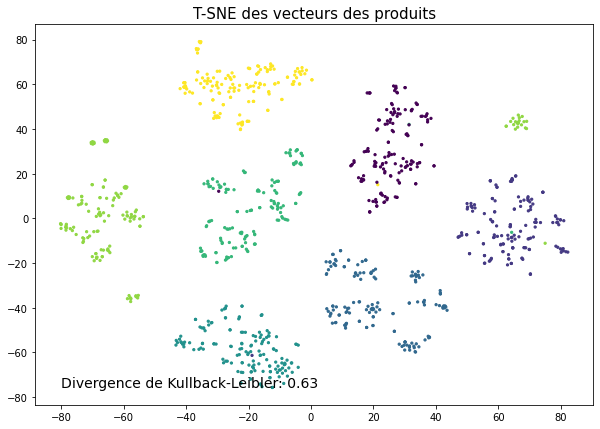

In [234]:
plt.figure(figsize=(10,7))
plt.title('T-SNE des vecteurs des produits', fontsize=15)
plt.scatter(vect_tsne[:,0], vect_tsne[:,1], s=5, c=predictions_forest)
_ = plt.text(min(vect_tsne[:, 0]), min(vect_tsne[:, 1]),
         "Divergence de Kullback-Leibler: %.2f" % tsne.kl_divergence_, fontsize=14)

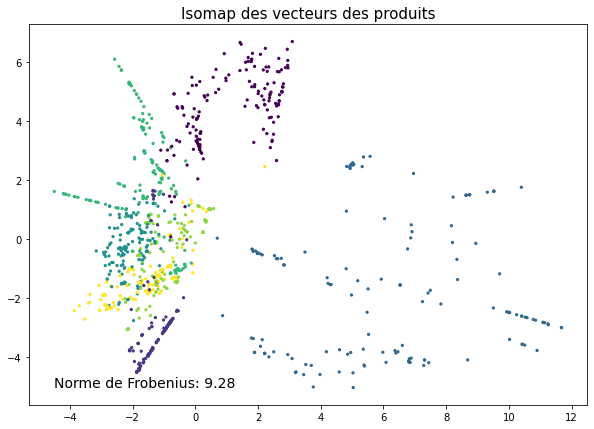

In [235]:
plt.figure(figsize=(10,7))
plt.title('Isomap des vecteurs des produits', fontsize=15)
plt.scatter(vect_iso[:,0], vect_iso[:,1], s=5, c=predictions_forest)
_ = plt.text(min(vect_iso[:, 0]), min(vect_iso[:, 1]),
         "Norme de Frobenius: %.2f" % isomap.reconstruction_error(), fontsize=14)

**Conclusion**: Entre la forêt aléatoire et le gradient boosting, qui on des performance égales, on choisi la forêt aléatoire car elle permet un temps d'exécution plus court.

# Analyse des erreurs

Voyons combien d'erreurs le modèle a commis

In [225]:
data['product_first_category_pred'] = g_rforest.predict(vect_prod)
data['product_first_category_pred'] = label_enc.inverse_transform(data['product_first_category_pred'])

In [226]:
is_error = data['product_first_category_pred'] != data['product_first_category']
prediction_errors = data[is_error]

In [227]:
precision = 1-len(prediction_errors)/float(len(data))
print("Précision sur l'ensemble des données: %.2f" % precision)
print("Nombre d'erreurs: %d" % len(prediction_errors))

Précision sur l'ensemble des données: 1.00
Nombre d'erreurs: 1


Voyons quelles catégories ont été confondues et quel est le nom du produit concerné.

In [229]:
categ_columns = ['product_first_category_pred', 'product_first_category', 'product_name']
prediction_errors[categ_columns]

,product_first_category_pred,product_first_category,product_name
127,Home Decor & Festive Needs,Beauty and Personal Care,Go Bonjour Stainless Steel 9 pc Manicure Kit


Essayons de voir plus en détail pourquoi ce produit a été confondu. Voyons l'image et le contenu du produit.

flipkart.com: buy go bonjour stainless steel 9 pc manicure kit for rs. 580 from flipkart.com. - lowest prices, only genuine products, 30 day replacement guarantee, free shipping. cash on delivery!


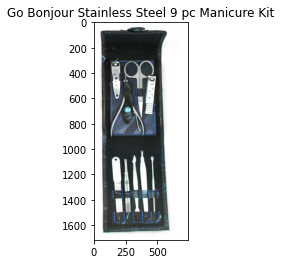

In [215]:
prod = prediction_errors.iloc[0]
img = cv.imread(in_dir+prod['image'])
plt.imshow(img)
plt.title(prod['product_name'])
print(prod['description'])

S'il y avait eu plus d'erreur, on aurait pu essayer de trouver des corrélation entre des catégories qui sont souvent confondus, avec un test de contingence de khi2 par exemple.

On peut faire plusieurs hypothèses sur l'origine de l'erreur:
- La présence de certains mot: 'Bonjour', 'stainless' ou 'replacement', qui peuvent être moins courants
- La multitude d'outils, qui a peut-être été associée à une boîte à outils

Pour vérifier ça, on peut:
- Comparer les scores de ces mots avec les scores les plus élevés de la catégorie.
- Vérifier la sortie du CNN seul

On commence par calculer l'importance moyenne des mots dans les catégories qui nous intéressent.

In [244]:
prods_home = data[data['product_first_category'] == 'Home Decor & Festive Needs']
prods_beauty = data[data['product_first_category'] == 'Beauty and Personal Care']

In [247]:
tfidf_home = tfidf_vects[prods_home.index]
tfidf_beauty = tfidf_vects[prods_beauty.index]

In [253]:
tfidf_home_mean = tfidf_home.mean(axis=0)
tfidf_beauty_mean = tfidf_beauty.mean(axis=0)

Voyons le contenu de la descriptions tokenisée, racinisée, lemminisée:

In [260]:
tokenize(prod['description'])

['flipkart',
 'com',
 'buy',
 'go',
 'bonjour',
 'stainless',
 'steel',
 'pc',
 'manicur',
 'kit',
 'r',
 'flipkart',
 'com',
 'lowest',
 'price',
 'genuin',
 'product',
 'day',
 'replac',
 'guarante',
 'free',
 'ship',
 'cash',
 'deliveri']

On extrait les indices dans le vocabulaire du TF-IDF des mots à étudier.

In [261]:
# inds_words: Indices des mots 'bonjour', 'stainless' et 'replac' dans le TF-IDF
inds_words = [tfidf.vocabulary_[word] for word in ['bonjour', 'stainless', 'replac']]

Voyons l'importance de chacun de ses mots dans chacune des 2 catégories.

In [262]:
tfidf_home_mean[inds_words]

array([0.        , 0.00152415, 0.03440312])

In [263]:
tfidf_beauty_mean[inds_words]

array([0.00277047, 0.00336646, 0.06719674])

Il semble que ces mots ne soient pas à l'origine de l'erreur, car ils sont effectivement plus représentatifs des produits de beauté. Cela n'est potentillement pas le cas, car on a éffectuer une réduction de dimensions, qui a causé une perte de d'information. Supponsons pour le moment que ce soit bien le cas.

Voyons maintenant si c'est l'image qui est trompeuse.

In [274]:
proba_max = max(input_from_cnn[prod.name])
ind_max = list(input_from_cnn[prod.name]).index(proba_max)

In [275]:
categ = label_enc.inverse_transform([ind_max])[0]
print("La catégorie prédite par le CNN est '%s' avec une probabilité de %.2f" % (categ, proba_max))

La catégorie prédite par le CNN est 'Home Decor & Festive Needs' avec une probabilité de 1.00


In [276]:
ind_categ_expected = label_enc.transform(['Beauty and Personal Care'])[0]
print("La catégorie réelle avait une probabilité de %.2f" % input_from_cnn[prod.name][ind_categ_expected])

La catégorie réelle avait une probabilité de 0.00


C'est donc le CNN qui a commis l'erreur, et c'est une grosse erreur car il était 'certain' que c'était la bonne catégorie.